# CAM-SE output analysis

Examples of simple analysis and plotting that can be done with CAM-SE output on the native cubed-sphere grid.

In [2]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
def make_map(data, lon, lat,):
    """This function plots data on a Mollweide projection map. 
    
    The data is transformed to the projection using Cartopy's `transform_points` method.

    The plot is made by triangulation of the points, producing output very similar to `pcolormesh`,
    but with triangles instead of rectangles used to make the image.
    """
    dataproj = ccrs.PlateCarree() # assumes data is lat/lon
    plotproj = ccrs.Mollweide()   # output projection 
    # set up figure / axes object, set to be global, add coastlines
    fig, ax = plt.subplots(figsize=(6,3), subplot_kw={'projection':plotproj})
    ax.set_global()
    ax.coastlines(linewidth=0.2)
    # this figures out the transformation between (lon,lat) and the specified projection
    tcoords = plotproj.transform_points(dataproj, lon.values, lat.values) # working with the projection
    xi=tcoords[:,0] != np.inf  # there can be bad points set to infinity, but we'll ignore them
    # print(f"{xi.shape = } --- Number of False: {np.count_nonzero(~xi)}")
    assert xi.shape[0] == tcoords.shape[0], f"Something wrong with shapes should be the same: {xi.shape = }, {tcoords.shape = }"
    tc=tcoords[xi,:]
    datai=data.values[xi]  # convert to numpy array, then subset
    # Use tripcolor --> triangluates the data to make the plot
    # rasterized=True reduces the file size (necessary for high-resolution for reasonable file size)
    # keep output as "img" to make specifying colorbar easy
    img = ax.tripcolor(tc[:,0],tc[:,1], datai, shading='gouraud', rasterized=True)
    cbar = fig.colorbar(img, ax=ax, shrink=0.4)
    return fig, ax

## Input data

In the following cell, specify the data source.

`location_of_hfiles` is a path object that points to the directory where data files should be.
`search_pattern` specifies what pattern to look for inside that directory.

**SIMPLIFICATION** If you want to just provide a path to a file, simply specify it by commenting (with `#`) the lines above "# WE need lat and lon", and replace with:
```
fils = "/path/to/your/data/file.nc"
```

## Parameters
Specify the name of the variable to be analyzed with `variable_name`.

To change the units of the variable, specify `scale_factor` and provide the new units string as `units`. Otherwise, just set `scale_factor` and `units`:

```
scale_factor = 1
units = ds["variable_name"].attrs["units"]
```

In [5]:
location_of_hfiles = Path("/glade/p/cesmdata/cseg/inputdata/cesm2_init/f.cam6_3_107.FLTHIST_v0a.ne30.clm5_1.001/1994-01-01/")
search_pattern = "f.cam6_3_107.FLTHIST_v0a.ne30.clm5_1.001.cam.h0.1993-12.nc"

fils = sorted(location_of_hfiles.glob(search_pattern))
if len(fils) == 1:
    ds = xr.open_dataset(fils[0])
else:
    print(f"Just so you konw, there are {len(fils)} files about to be loaded.")
    ds = xr.open_mfdataset(fils)

# We need lat and lon:
lat = ds['lat']
lon = ds['lon']

# Choose what variable to plot:
variable_name = "PRECT"

# If needed, select scale factor and new units:
scale_factor = 86400. * 1000. # m/s -> mm/day
units = "mm/day"

data = scale_factor * ds[variable_name]
data.attrs['units'] = units

In [6]:
# temporal averaging
# simplest case, just average over times:
data_avg = data.mean(dim='time')

In [12]:
#
# Global average
#
data_global_average = data_avg.weighted(ds['area']).mean()
print(f"The area-weighted average of the time-mean data is: {data_global_average.item()}")

KeyError: 'area'

In [13]:
#
# Regional average using a (logical) rectangle
#
west_lon = 110.0
east_lon = 200.0
south_lat = -30.0
north_lat = 30.0

# To reduce to the region, we need to know which indices of ncol dimension are inside the boundary

region_inds = np.argwhere(((lat > south_lat)&(lat < north_lat)&(lon>west_lon)&(lon<east_lon)).values)
print(f"The number of grid columns inside the specified region is {region_inds.shape[0]}")

# get the area associated with each selected column. Note the region_inds array needs to be flattened to use in isel.
region_area = ds['area'].isel(ncol=region_inds.flatten()) 
# get the data in the region:
region_data = data_avg.isel(ncol=region_inds.flatten())

data_region_average = region_data.weighted(region_area).mean()
print(f"The area-weighted average in thee region [{west_lon}E-{east_lon}E, {south_lat}-{north_lat}] is: {data_region_average.item()}")

The number of grid columns inside the specified region is 4544


KeyError: 'area'

ValueError: x and y arrays must have the same length

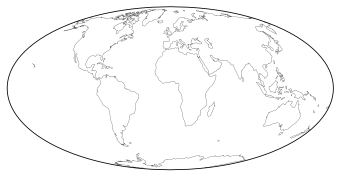

In [14]:
# plot the map of the time average 
# using the function defined above.
fig1, ax1 = make_map(data_avg, lon, lat,)